In [1]:
!pip install contractions

import pandas as pd
import re
import contractions
from nltk.corpus import stopwords
import en_core_web_sm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM, Dense, Dropout, GlobalMaxPool1D
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#LOAD AND COMBINE TWO VERSIONS
s1 = pd.read_json(
        '../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json',
        lines=True)

s2 = pd.read_json(
        '../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json',
        lines=True)

x1 = s1[['headline', 'is_sarcastic']]
x2 = s2[['headline', 'is_sarcastic']]

x = pd.concat([x1, x2], ignore_index=True)
x.columns = ['text', 'label']
x = x.drop_duplicates(subset=['text', 'label'], keep='first')

In [3]:
#TEXT PREPROCESS
#FIX CONTRACTIONS
x['text'] = x['text'].apply(lambda x: contractions.fix(x))

#REMOVE PUNCTUATION
x['text'] = x['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

#CONVERT TO LOWERCASE
def lowerCase(input_str):
    input_str = input_str.lower()
    return input_str

x['text'] = x['text'].apply(lambda x: lowerCase(x))

#REMOVE STOPWORDS AND LEMMATIZATION
sp = en_core_web_sm.load()
stpw = set(stopwords.words('english'))

def lemma(input_str):
    s = sp(input_str)
    
    input_list = []
    for word in s:
        w = word.lemma_
        input_list.append(w)
        
    output = ' '.join(word for word in input_list if word not in stpw)
    return output

X = []
text = list(x['text'])
for t in text:
    X.append(lemma(t))
    
X[0]

'former versace store clerk sue secret black code minority shopper'

In [4]:
embed_size = 100

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X1 = tokenizer.texts_to_sequences(X)
X1 = pad_sequences(X1)

y = x['label'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.2,
                                                    random_state = 42)

embedding_path = '../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'

embeddings_index = {}
f = open(embedding_path)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()

embedding_matrix = np.random.normal(emb_mean, emb_std, (len(word_index) + 1, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential()
model.add(Embedding(len(word_index) + 1, embed_size, weights=[embedding_matrix]))
model.add(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=64, epochs=3)
y_pred = model.predict([X_test], batch_size=1024, verbose=1)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/3
22802/22802 [==============================] - 38s 2ms/step - loss: 0.5466 - accuracy: 0.7162
Epoch 2/3
22802/22802 [==============================] - 37s 2ms/step - loss: 0.3775 - accuracy: 0.8321
Epoch 3/3
5701/5701 [==============================] - 1s 251us/step


AUC: 0.9083258385241825


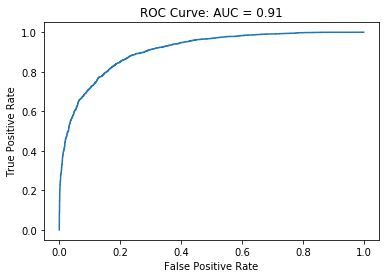

In [5]:
#PLOT
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)

auc = np.trapz(tpr,fpr)
print('AUC:', auc)  
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: AUC = {0:0.2f}'.format(auc))
plt.plot(fpr,tpr)
plt.show()

In [6]:
#ACCURACY
y_pred1 = y_pred > 0.5
metrics.accuracy_score(y_pred1, y_test)

0.8238905455183301

In [7]:
#CONFUSION MATRIX
metrics.confusion_matrix(y_pred1, y_test)

array([[2403,  416],
       [ 588, 2294]])